# Leaky ReLUs and LipMIP
I've done a fairly significant refactor from my previous github repo in order to be slightly more general in both the bound propagation and LipMIP process. This notebook will explain how to play around with these things. I'll demonstrate an example over a 2-dimensional dataset with 2 classes. As always, let me know if you have questions or if anything is broken 

In [1]:
# First we need to import everything we'll need:

# System/python packages 
import numpy as np 
import torch
import torch.nn as nn 
import torch.functional as F 
import gurobipy as gb # You'll need to install gurobi on your machine and get it working 
# Vincent has good instructions for how to install gurobi: 
# https://vtjeng.github.io/MIPVerify.jl/latest/#Installation-1

# Imports within this project 
import sys
sys.path.append('..')
import bound_prop as bp
import neural_nets.data_loaders as dl 
import neural_nets.train as train 
from relu_nets import ReLUNet
from general_net import GenNet
import utilities as utils
from hyperbox import Hyperbox, LinfBallFactory, BooleanHyperbox
from zonotope import Zonotope
import lipMIP2 as lm


# Step 1: Building and training networks
For convenience, I built the `GenNet` class which is a wrapper for PyTorch neural networks. Right now I just have LipMIP support for fully-connected layers (no convolutions), though I can build convolutions if needed. I'll demonstrate how to build and train a neural network with ReLU and LeakyReLU nonlinearities here:

In [2]:
# 1.1: Build a neural network
# (two ways to do this: either build the network and plug it into the wrapper, or use the shortcut constructor)

# the standard way to build a pytorch neural network
simple_seq = nn.Sequential(nn.Linear(2, 10), nn.ReLU(), nn.Linear(10, 20), nn.ReLU(), nn.Linear(20, 2))
simple_net1 = GenNet(simple_seq)

# Or the constructor shortcut (just list the 'layer sizes', and which nonlinearity you'd like)
relu_net = GenNet.fc_net([2, 20, 20, 20, 2], nonlinearity=nn.ReLU) # second argument is a constructor! 

# We'll need a constructor for a specific type of leakyReLU
leaky_constructor = lambda : nn.LeakyReLU(negative_slope=0.1)
leaky_net = GenNet.fc_net([2, 20, 20, 20, 2], nonlinearity=leaky_constructor)

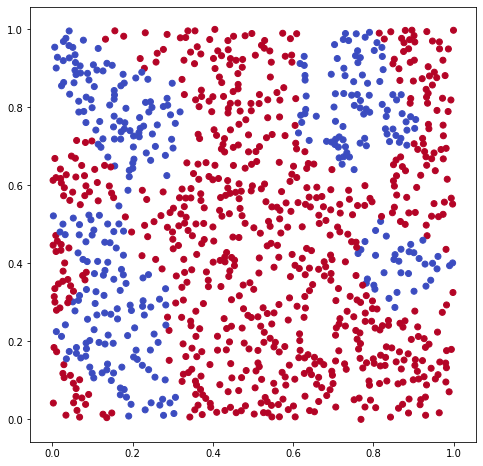

In [3]:
# 1.2: Construct a dataset 
# I've built easy-access methods for datasets in the package imported as 'dl'. 
# You can access MNIST here, as well as some synthetic datasets that are easier to sandbox 
# (the standard CIFAR dataset [find some tutorial online] should plug&play)-

# For the purposes of demonstration, I'll use a toy 2d dataset so we can visualize things 
data_params = dl.RandomKParameters(1024, 32, radius=0.005, dimension=2, num_classes=2)
dataset = dl.RandomDataset(data_params, random_seed=1234)
dataset.split_train_val(0.75)
ax = dataset.plot_2d() # visualize dataset

In [4]:
# 1.3: training a network 
# I also made some classes to make training very easy. 
# The TrainParameters object holds the training/validation sets, as well as the:
# - number of epochs to train for 
# - optimization algorithm to use 
# - loss function to use 
# - optional callback for more custom logging 
# Then the training can be viewed just as a function of the network, and these parameters 

num_epochs = 1000 
# optimizer is ADAM by default
cross_entropy = train.XEntropyReg()
#l1_reg = train.LpWeightReg(scalar=1e-5)
loss_functional = train.LossFunctional(regularizers=[cross_entropy])#, l1_reg])
# Loss function is L(net):= CrossEntropy(net) + 1e-5 * ||net||_1

train_params = train.TrainParameters(dataset.train_data, dataset.val_data, num_epochs, 
                                     loss_functional=loss_functional, test_after_epoch=100)


Epoch 00 | Accuracy: 30.08
Epoch 100 | Accuracy: 77.34
Epoch 200 | Accuracy: 83.20
Epoch 300 | Accuracy: 86.72
Epoch 400 | Accuracy: 87.50
Epoch 500 | Accuracy: 87.11
Epoch 600 | Accuracy: 87.50
Epoch 700 | Accuracy: 87.89
Epoch 800 | Accuracy: 87.50
Epoch 900 | Accuracy: 87.89
Epoch 1000 | Accuracy: 89.45


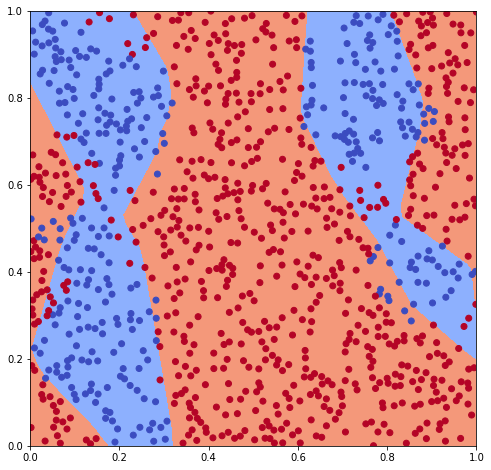

In [5]:
# Then training and visualizing the decision boundaries of these networks is easy:
train.training_loop(relu_net, train_params) #<---- training step

# And then we can display: 
ax = relu_net.display_decision_bounds((0.0, 1.0), (0.0, 1.0), 50)
dataset.plot_2d(ax=ax)


Epoch 00 | Accuracy: 30.08
Epoch 100 | Accuracy: 82.03
Epoch 200 | Accuracy: 86.33
Epoch 300 | Accuracy: 91.41
Epoch 400 | Accuracy: 92.19
Epoch 500 | Accuracy: 92.97
Epoch 600 | Accuracy: 93.75
Epoch 700 | Accuracy: 94.14
Epoch 800 | Accuracy: 93.75
Epoch 900 | Accuracy: 94.14
Epoch 1000 | Accuracy: 95.31


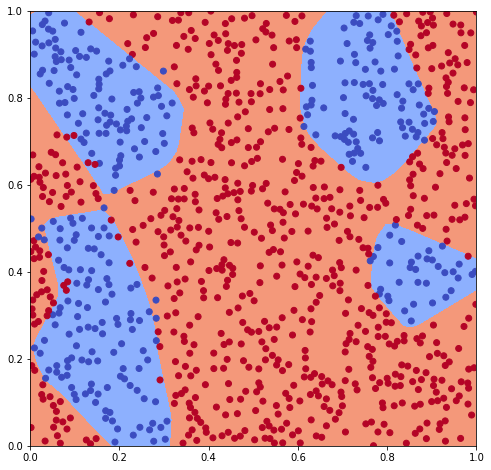

In [6]:
# Then training and visualizing the decision boundaries of these networks is easy:
train.training_loop(leaky_net, train_params) #<---- training step

# And then we can display: 
ax = leaky_net.display_decision_bounds((0.0, 1.0), (0.0, 1.0), 50)
dataset.plot_2d(ax=ax)


# Step 2: Evaluating Lipschitz Constants Exactly
With both a ReLU and LeakyReLU network in hand, we can evaluate the Lipschitz constant using my Mixed-Integer Programming framework. Recall that the Lipschitz constant of a scalar-valued (lipschitz continuous function) is the supremal norm of the generalized gradients. The networks we have trained are not scalar-valued, so we evaluate the Lipschitz constant of the class difference: 
$$g(x) = f_1(x) - f_2(x) = [1, 2]^T f(x)$$

There are still some choices to be made:
1. Which bound propagation scheme to use 
2. Which region to evaluate the Lipschitz constant over
3. How tightly we want to evaluate the Lipschitz constant

For question 1: the standard Hyperbox bound propagation scheme is typically fine. Other choices include the Zonotope or Polytope bound propagation schemes (ongoing, semi-unpublished work), which make the MIP go faster, but are more expensive to set up. 

For question 2: Our network is small enough that we can evaluate over the whole $[0,1]^2$ domain, but smaller regions are allowed, too.

For question 3: Again, our network is small enough to compute it exactly, but relaxations or early-stopping are supported also.

In [7]:
# 2.1 Setting up the LipMIP instance 
# -- to answer question 1 and tell LipMIP that we want to use the Hyperbox scheme, we use the following object 
hbox_prop = bp.AbstractParams.hyperbox_params()

# -- to evaluate over the whole [0,1]^2 hyperbox 
hbox_range = Hyperbox.build_unit_hypercube(2)

# -- to evaluate Lipschitz constant of f_1(x)-f_2(x)
c_vec = torch.tensor([1.0, -1.0])

In [8]:
# 2.2: running LipMIP for ReLu/LeakyReLU net:
relu_lipmip = lm.LipMIP(relu_net, hbox_prop, verbose=True, num_threads=2)
relu_result = relu_lipmip.compute_max_lipschitz(hbox_range, c_vec)

leaky_lipmip = lm.LipMIP(leaky_net, hbox_prop, verbose=True, num_threads=2)
leaky_result = leaky_lipmip.compute_max_lipschitz(hbox_range, c_vec)

Changed value of parameter Threads to 2
   Prev: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 481 rows, 294 columns and 2645 nonzeros
Model fingerprint: 0x47aadbcf
Variable types: 251 continuous, 43 integer (43 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-06, 7e+02]
  RHS range        [1e-06, 1e+03]
Presolve removed 221 rows and 123 columns
Presolve time: 0.02s
Presolved: 260 rows, 171 columns, 1684 nonzeros
Variable types: 133 continuous, 38 integer (38 binary)

Root relaxation: objective 9.444283e+02, 174 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  944.42834    0   23          -  944.42834      -     -    0s
     0     0  900.14166    0   27          -  900.14166      -     -    0s
     0     0  8

In [9]:
# 2.3: Evaluating the results:
# The output of .compute_max_lipschitz is a LipResult object, which is just a wrapper for various objects.
# The most important ones are (value, best_x, compute_time) which describe the
# - Lipschitz value
# - input point that lies in the linear region attaining this value* 
# - time in seconds it took to compute this 

#* Note that the best_x will likely lie on the boundary of a linear region and pyTorch will often miscompute 
#  the value if you ask for gradients directly at that point -- you need to find a point in the interior of that 
#  linear region (working on this method...)

relu_result.print_result("ReLU Net")
print('\n')
leaky_result.print_result("Leaky Net")

LipMIP Output for network:  ReLU Net
	 value 432.00535098525734
	 best_x [0.         0.18004195]
	 compute_time 0.3785984516143799


LipMIP Output for network:  Leaky Net
	 value 396.76668415955123
	 best_x [0.56669867 0.89581277]
	 compute_time 1.4831607341766357


# Stopping here:
Okay, that should suffice for your purposes -- I'll work on getting convolution layers built up, but this is more complicated (because the backprop is kinda messy), but for fully connected nets.

Toying around with this, it doesn't look like Leaky ReLU's directly dampen the Lipschitz constant under the same training scheme (a significant amount). But it's also evident that tweaks to the training scheme (regularization/architecture/number of epochs) can dramatically affect the Lipschitz constant, and datasets or using L*ReLU . Unfortunately, this framework doesn't extend to nonlinearities that are not piecewise-linear, and AFAIK, there is no algorithm to solve this setting exactly. Future work maybe? 